Q-Learning Robot Navigation Controller
6ELEN018W Applied Robotics Coursework - Part 1

Maze size: 8x7
Number of free positions: 36
Training Q-learning for 36 goal positions...
Completed 5/36 goals
Completed 10/36 goals
Completed 15/36 goals
Completed 20/36 goals
Completed 25/36 goals
Completed 30/36 goals
Completed 35/36 goals
Training complete!

Testing Learned Policy

Start: (0, 0), Goal: (7, 6)
Path length: 13 steps
Path: (0, 0) -> (1, 0) -> (2, 0) -> (2, 1) -> (2, 2)...


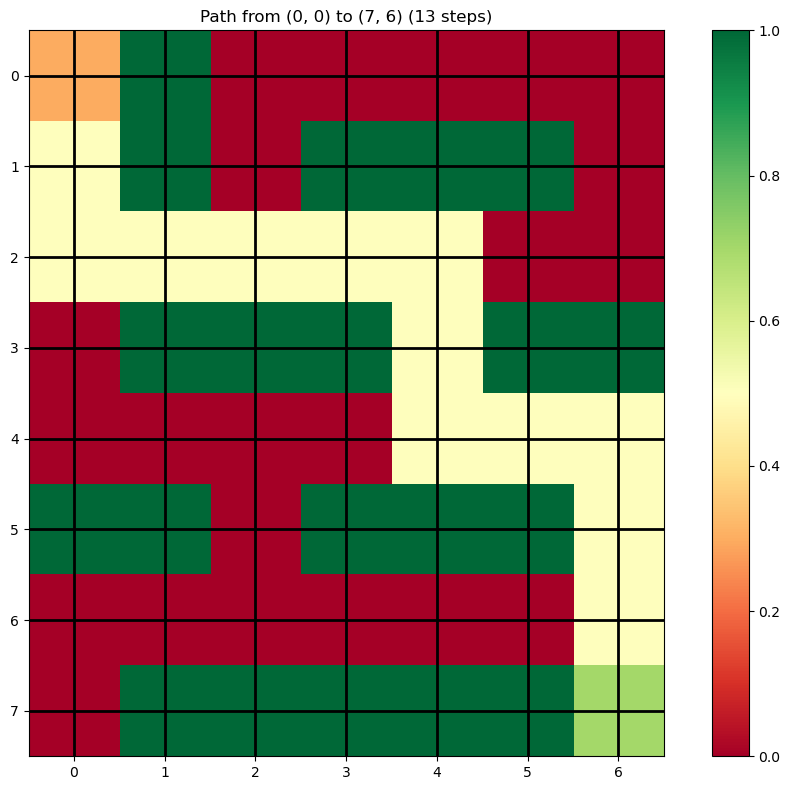


Start: (7, 0), Goal: (0, 6)
Path length: 13 steps
Path: (7, 0) -> (6, 0) -> (6, 1) -> (6, 2) -> (5, 2)...


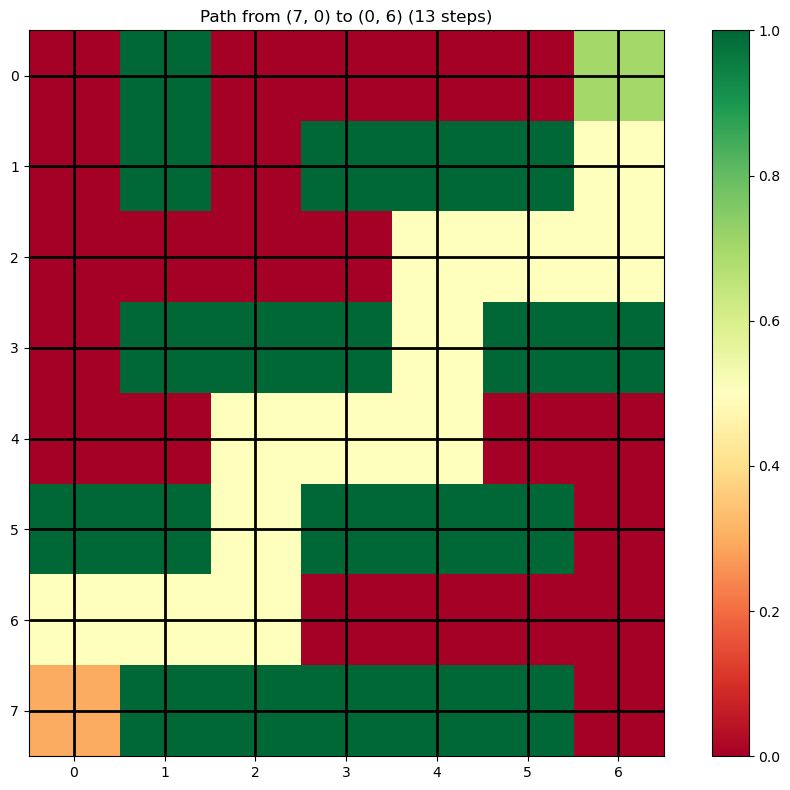


Start: (2, 3), Goal: (5, 2)
Path length: 6 steps
Path: (2, 3) -> (2, 4) -> (3, 4) -> (4, 4) -> (4, 3)...


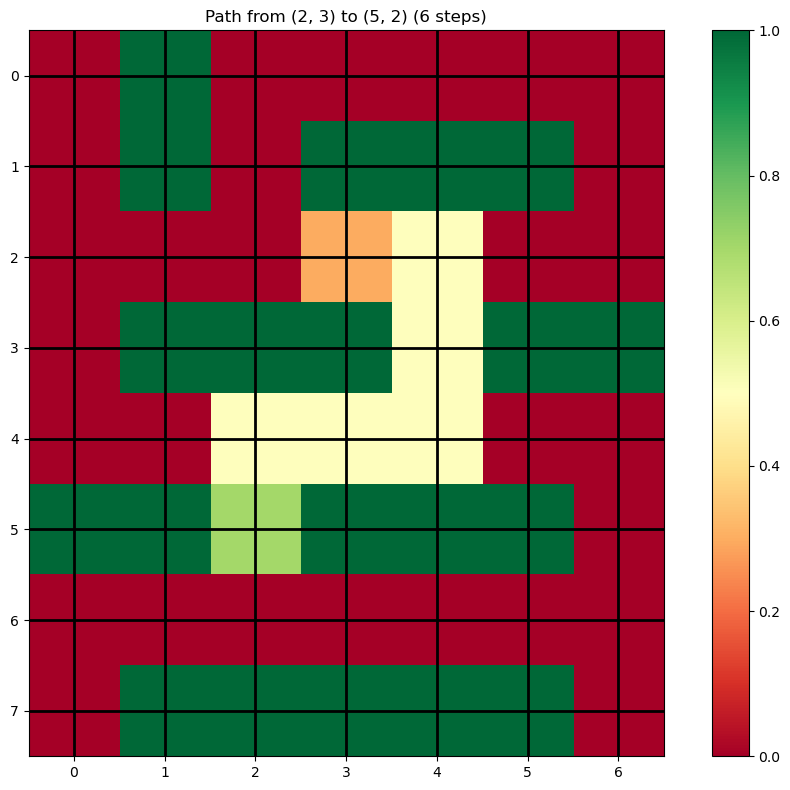


Showing training convergence for goal (7, 6)...


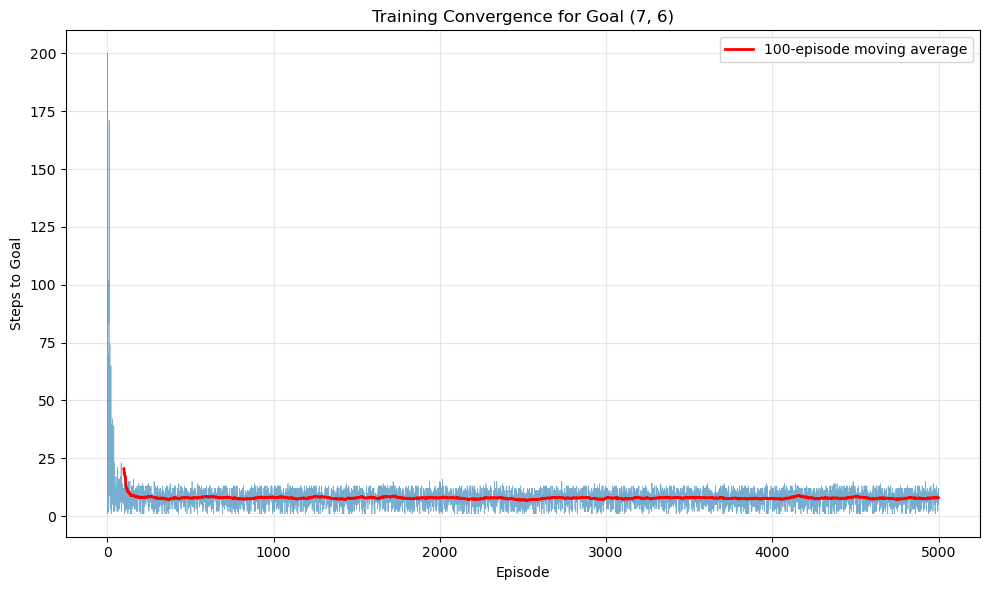


Q-table saved to 'q_table_part1.pkl'

Part 1 Complete!


In [23]:
"""
6ELEN018W Applied Robotics - Coursework Part 1
Q-Learning Based Robot Navigation Controller

Student: [20223072 / w1961648]
Module: Applied Robotics
Academic Year: 2025/2026

This implementation demonstrates reinforcement learning for robot navigation
in a maze environment using the Q-learning algorithm.
"""

import numpy as np
import random
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

class MazeEnvironment:
    """
    Represents the maze environment.
    The maze is an 8x7 grid where black squares represent obstacles.
    """
    
    def __init__(self):
        self.maze = np.array([
            [0, 1, 0, 0, 0, 0, 0],
            [0, 1, 0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0]
        ])
        
        self.rows, self.cols = self.maze.shape
        self.action_space = ['N', 'E', 'S', 'W']
        
    def is_valid_position(self, row, col):
        if row < 0 or row >= self.rows or col < 0 or col >= self.cols:
            return False
        return self.maze[row, col] == 0
    
    def get_next_state(self, current_row, current_col, action):
        next_row, next_col = current_row, current_col
        
        if action == 'N':
            next_row = current_row - 1
        elif action == 'S':
            next_row = current_row + 1
        elif action == 'E':
            next_col = current_col + 1
        elif action == 'W':
            next_col = current_col - 1
            
        if not self.is_valid_position(next_row, next_col):
            return current_row, current_col
        
        return next_row, next_col
    
    def get_all_free_positions(self):
        positions = []
        for i in range(self.rows):
            for j in range(self.cols):
                if self.maze[i, j] == 0:
                    positions.append((i, j))
        return positions


class QLearningController:
    """
    Q-Learning implementation for robot navigation.
    Learns optimal actions to reach goal from any starting position.
    """
    
    def __init__(self, environment, learning_rate=0.1, discount_factor=0.9, 
                 epsilon=0.1, epsilon_decay=0.995, min_epsilon=0.01):
        self.env = environment
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
        
    def get_reward(self, current_pos, next_pos, goal_pos):
        if next_pos == goal_pos:
            return 100.0
        elif next_pos == current_pos:
            return -5.0
        else:
            return -0.1
    
    def select_action(self, state, goal, training=True):
        if training and random.random() < self.epsilon:
            return random.choice(self.env.action_space)
        else:
            state_key = (state[0], state[1])
            goal_key = (goal[0], goal[1])
            q_values = {action: self.Q[goal_key][state_key][action] 
                       for action in self.env.action_space}
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            return random.choice(best_actions)
    
    def train_for_goal(self, goal_pos, num_episodes=5000, max_steps_per_episode=200):
        goal_key = (goal_pos[0], goal_pos[1])
        free_positions = self.env.get_all_free_positions()
        valid_starts = [pos for pos in free_positions if pos != goal_pos]
        episode_lengths = []
        
        for episode in range(num_episodes):
            start_pos = random.choice(valid_starts)
            current_pos = start_pos
            steps = 0
            
            while current_pos != goal_pos and steps < max_steps_per_episode:
                action = self.select_action(current_pos, goal_pos, training=True)
                next_pos = self.env.get_next_state(current_pos[0], current_pos[1], action)
                reward = self.get_reward(current_pos, next_pos, goal_pos)
                
                current_key = (current_pos[0], current_pos[1])
                next_key = (next_pos[0], next_pos[1])
                
                next_q_values = [self.Q[goal_key][next_key][a] 
                               for a in self.env.action_space]
                max_next_q = max(next_q_values) if next_q_values else 0.0
                
                current_q = self.Q[goal_key][current_key][action]
                self.Q[goal_key][current_key][action] = current_q + self.alpha * (
                    reward + self.gamma * max_next_q - current_q
                )
                
                current_pos = next_pos
                steps += 1
            
            episode_lengths.append(steps)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
        return episode_lengths
    
    def train_all_goals(self, num_episodes=5000):
        free_positions = self.env.get_all_free_positions()
        training_stats = {}
        print(f"Training Q-learning for {len(free_positions)} goal positions...")
        
        for idx, goal_pos in enumerate(free_positions):
            self.epsilon = 0.1
            episode_lengths = self.train_for_goal(goal_pos, num_episodes)
            training_stats[goal_pos] = episode_lengths
            if (idx + 1) % 5 == 0:
                print(f"Completed {idx + 1}/{len(free_positions)} goals")
        
        print("Training complete!")
        return training_stats
    
    def get_optimal_path(self, start_pos, goal_pos, max_steps=100):
        path = [start_pos]
        current_pos = start_pos
        steps = 0
        
        while current_pos != goal_pos and steps < max_steps:
            action = self.select_action(current_pos, goal_pos, training=False)
            next_pos = self.env.get_next_state(current_pos[0], current_pos[1], action)
            
            if next_pos == current_pos:
                for action in self.env.action_space:
                    test_pos = self.env.get_next_state(current_pos[0], current_pos[1], action)
                    if test_pos != current_pos:
                        next_pos = test_pos
                        break
            
            path.append(next_pos)
            current_pos = next_pos
            steps += 1
            
            if len(path) > 10 and path[-1] == path[-5]:
                break
        
        return path
    
    def save_q_table(self, filename='q_table.pkl'):
        """Save learned Q-values for future use."""
        q_dict = {}
        for goal_key, states in self.Q.items():
            q_dict[goal_key] = {}
            for state_key, actions in states.items():
                q_dict[goal_key][state_key] = dict(actions)
        
        with open(filename, 'wb') as f:
            pickle.dump(q_dict, f)

    def load_q_table(self, filename='q_table.pkl'):
        """Load previously learned Q-values."""
        with open(filename, 'rb') as f:
            loaded_q = pickle.load(f)
        
        self.Q = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
        for goal_key, states in loaded_q.items():
            for state_key, actions in states.items():
                for action, value in actions.items():
                    self.Q[goal_key][state_key][action] = value


def visualise_maze_with_path(env, path, start_pos, goal_pos):
    fig, ax = plt.subplots(figsize=(10, 8))
    maze_display = np.copy(env.maze).astype(float)
    
    for i, pos in enumerate(path[1:-1], 1):
        if maze_display[pos[0], pos[1]] == 0:
            maze_display[pos[0], pos[1]] = 0.5
    
    maze_display[start_pos[0], start_pos[1]] = 0.3
    maze_display[goal_pos[0], goal_pos[1]] = 0.7
    
    im = ax.imshow(maze_display, cmap='RdYlGn', interpolation='nearest')
    
    ax.set_xticks(np.arange(env.cols))
    ax.set_yticks(np.arange(env.rows))
    ax.grid(which='both', color='black', linestyle='-', linewidth=2)
    
    ax.set_title(f'Path from {start_pos} to {goal_pos} ({len(path)-1} steps)')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


def plot_training_convergence(training_stats, goal_pos):
    episode_lengths = training_stats[goal_pos]
    
    plt.figure(figsize=(10, 6))
    plt.plot(episode_lengths, alpha=0.6, linewidth=0.5)
    
    window = 100
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(episode_lengths)), moving_avg, 
                color='red', linewidth=2, label=f'{window}-episode moving average')
    
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    plt.title(f'Training Convergence for Goal {goal_pos}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==================== MAIN EXECUTION ====================

print("="*60)
print("Q-Learning Robot Navigation Controller")
print("6ELEN018W Applied Robotics Coursework - Part 1")
print("="*60)

# Initialise environment
env = MazeEnvironment()
print(f"\nMaze size: {env.rows}x{env.cols}")
print(f"Number of free positions: {len(env.get_all_free_positions())}")

# Initialise Q-learning controller
controller = QLearningController(
    environment=env,
    learning_rate=0.1,
    discount_factor=0.9,
    epsilon=0.1,
    epsilon_decay=0.995,
    min_epsilon=0.01
)

# Train for all goals
training_stats = controller.train_all_goals(num_episodes=5000)

# Test examples
print("\n" + "="*60)
print("Testing Learned Policy")
print("="*60)

test_cases = [
    ((0, 0), (7, 6)),
    ((7, 0), (0, 6)),
    ((2, 3), (5, 2)),
]

for start, goal in test_cases:
    if env.is_valid_position(start[0], start[1]) and env.is_valid_position(goal[0], goal[1]):
        path = controller.get_optimal_path(start, goal)
        print(f"\nStart: {start}, Goal: {goal}")
        print(f"Path length: {len(path)-1} steps")
        print(f"Path: {' -> '.join([str(p) for p in path[:5]])}{'...' if len(path) > 5 else ''}")
        
        visualise_maze_with_path(env, path, start, goal)

# Show training convergence for one goal
sample_goal = (7, 6)
print(f"\nShowing training convergence for goal {sample_goal}...")
plot_training_convergence(training_stats, sample_goal)

# Save Q-table
controller.save_q_table('q_table_part1.pkl')
print("\nQ-table saved to 'q_table_part1.pkl'")

print("\n" + "="*60)
print("Part 1 Complete!")
print("="*60)

Neural Network Robot Navigation Controller
6ELEN018W Applied Robotics Coursework - Part 2

[Step 1] Generating Training Data from Q-Learning...
Loaded Q-table from q_table_part1.pkl
Generating dataset from 36 positions...
Generated 1260 training samples
Dataset saved to training_data_part2.csv

[Step 2] Preparing Data...
Training set size: 945
Testing set size: 315
Feature shape: (945, 4)


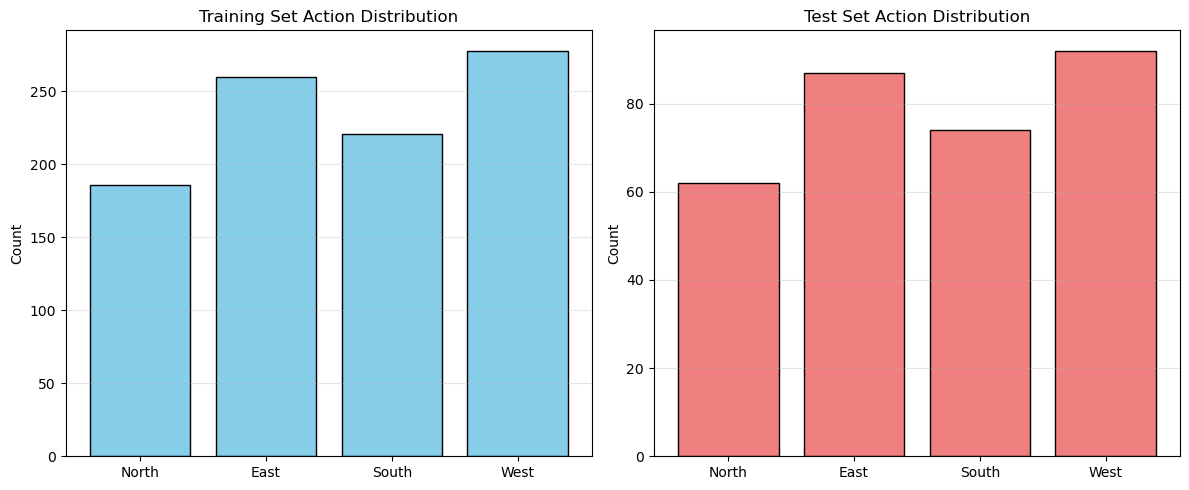


[Step 3] Training Neural Network...

Training Neural Network...
Architecture: (64, 32)
Learning rate: 0.001
Training completed in 100 iterations
Final training loss: 0.784780


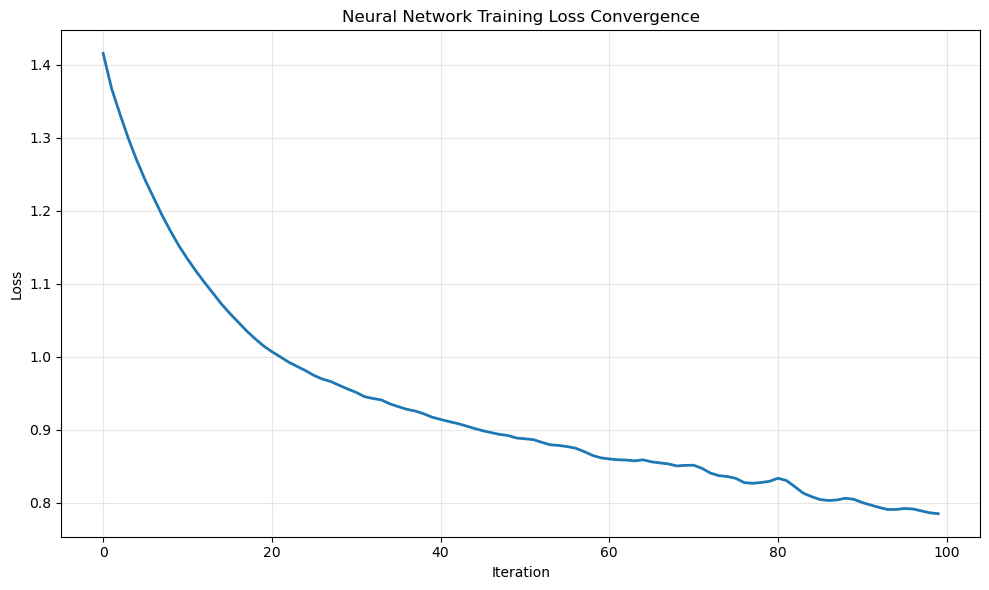


[Step 4] Evaluating Performance...

Neural Network Performance Evaluation
Test Accuracy: 58.41%
Correctly classified: 184/315

Classification Report:
              precision    recall  f1-score   support

       North      0.519     0.435     0.474        62
        East      0.582     0.609     0.596        87
       South      0.557     0.595     0.575        74
        West      0.645     0.652     0.649        92

    accuracy                          0.584       315
   macro avg      0.576     0.573     0.573       315
weighted avg      0.582     0.584     0.582       315


Root Mean Square Error (RMSE): 1.0405


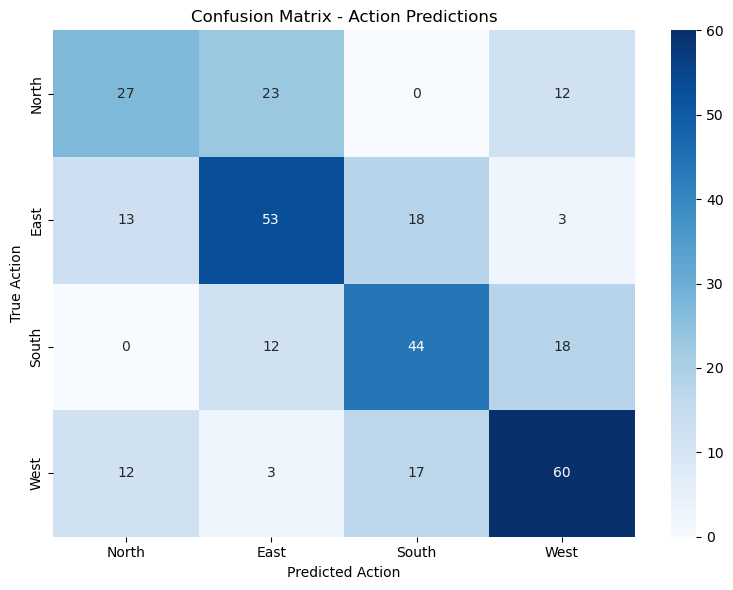


[Step 5] Testing Navigation on Specific Routes...

Testing route: (0, 0) → (7, 6)


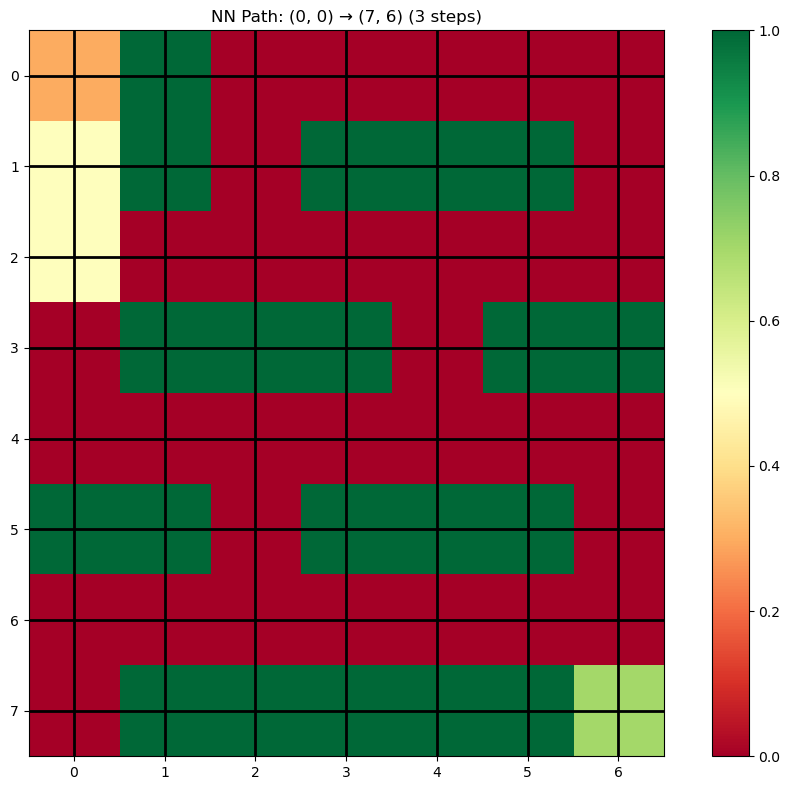

Path length: 3 steps
Reached goal: False

Testing route: (7, 0) → (0, 6)


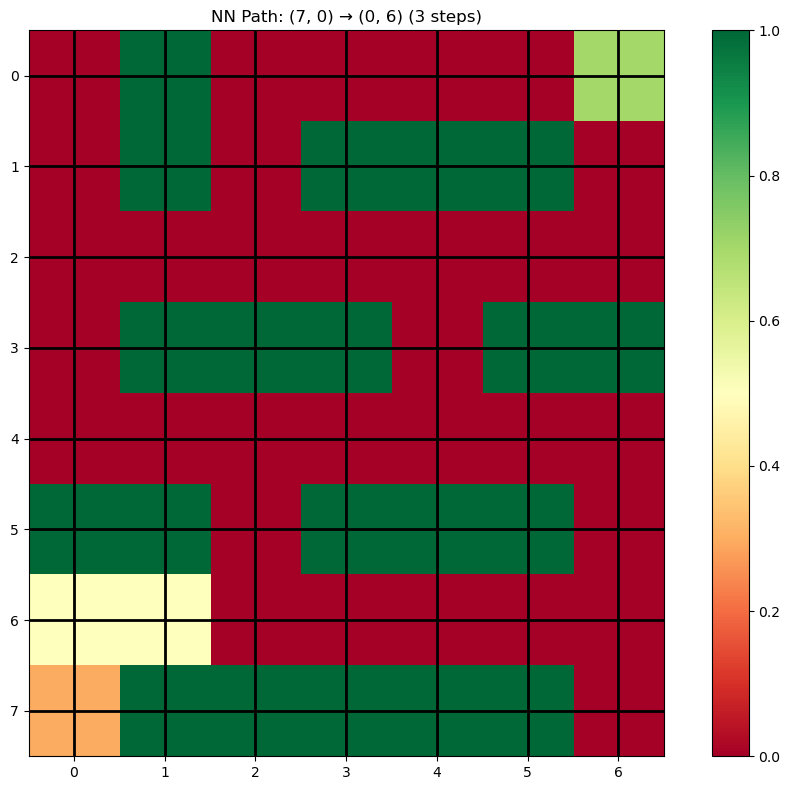

Path length: 3 steps
Reached goal: False

Testing route: (2, 3) → (5, 2)


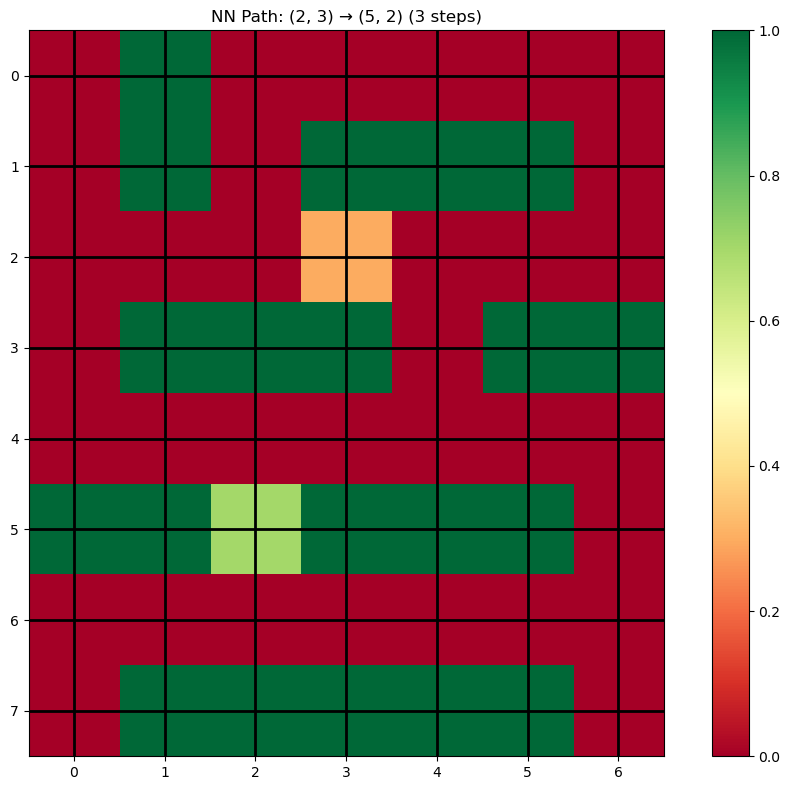

Path length: 3 steps
Reached goal: False

Model saved to nn_model_part2.pkl

Part 2 Complete!


In [24]:
"""
6ELEN018W Applied Robotics - Coursework Part 2
Neural Network Based Robot Navigation Controller

Student: [20223072 / w1961648]
Module: Applied Robotics
Academic Year: 2025/2026

This implementation uses a Multi-Layer Perceptron (MLP) to learn robot navigation
by training on optimal actions derived from Q-learning (Part 1).
"""

import numpy as np
import pandas as pd
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class MazeEnvironment:
    """
    Same maze environment as Part 1.
    Included here for consistency and self-contained execution.
    """
    
    def __init__(self):
        self.maze = np.array([
            [0, 1, 0, 0, 0, 0, 0],
            [0, 1, 0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0]
        ])
        
        self.rows, self.cols = self.maze.shape
        self.action_space = ['N', 'E', 'S', 'W']
        
    def is_valid_position(self, row, col):
        if row < 0 or row >= self.rows or col < 0 or col >= self.cols:
            return False
        return self.maze[row, col] == 0
    
    def get_next_state(self, current_row, current_col, action):
        next_row, next_col = current_row, current_col
        
        if action == 'N':
            next_row = current_row - 1
        elif action == 'S':
            next_row = current_row + 1
        elif action == 'E':
            next_col = current_col + 1
        elif action == 'W':
            next_col = current_col - 1
            
        if not self.is_valid_position(next_row, next_col):
            return current_row, current_col
        
        return next_row, next_col
    
    def get_all_free_positions(self):
        positions = []
        for i in range(self.rows):
            for j in range(self.cols):
                if self.maze[i, j] == 0:
                    positions.append((i, j))
        return positions


class DataGenerator:
    """
    Generates training data from Q-learning results.
    Creates dataset with 756 rows as specified in coursework.
    """
    
    def __init__(self, q_table_path='q_table_part1.pkl'):
        self.env = MazeEnvironment()
        self.action_to_int = {'N': 0, 'E': 1, 'S': 2, 'W': 3}
        self.int_to_action = {0: 'N', 1: 'E', 2: 'S', 3: 'W'}
        
        # Load Q-table from Part 1
        try:
            with open(q_table_path, 'rb') as f:
                self.Q = pickle.load(f)
            print(f"Loaded Q-table from {q_table_path}")
        except FileNotFoundError:
            print(f"Error: {q_table_path} not found. Please run Part 1 first.")
            self.Q = None
    
    def get_optimal_action_from_q(self, current_pos, goal_pos):
        """
        Extract optimal action from Q-table for given state.
        """
        current_key = (current_pos[0], current_pos[1])
        goal_key = (goal_pos[0], goal_pos[1])
        
        if goal_key not in self.Q or current_key not in self.Q[goal_key]:
            # If no Q-values exist, return random action
            return random.choice(list(self.action_to_int.keys()))
        
        # Get Q-values for all actions
        q_values = self.Q[goal_key][current_key]
        
        # Find action with maximum Q-value
        max_q = -float('inf')
        best_action = 'N'
        
        for action in ['N', 'E', 'S', 'W']:
            if action in q_values and q_values[action] > max_q:
                max_q = q_values[action]
                best_action = action
        
        return best_action
    
    def generate_dataset(self):
        """
        Generate dataset with format:
        (current_x, current_y, goal_x, goal_y) -> optimal_action
        
        Creates 756 samples (28 free positions × 27 other positions)
        """
        free_positions = self.env.get_all_free_positions()
        
        data = []
        
        print(f"Generating dataset from {len(free_positions)} positions...")
        
        for current_pos in free_positions:
            for goal_pos in free_positions:
                # Skip if current position is the goal
                if current_pos == goal_pos:
                    continue
                
                # Get optimal action from Q-table
                optimal_action = self.get_optimal_action_from_q(current_pos, goal_pos)
                
                # Create data row: [current_x, current_y, goal_x, goal_y, action]
                data.append([
                    current_pos[0], 
                    current_pos[1], 
                    goal_pos[0], 
                    goal_pos[1],
                    self.action_to_int[optimal_action]
                ])
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=[
            'current_x', 'current_y', 'goal_x', 'goal_y', 'action'
        ])
        
        print(f"Generated {len(df)} training samples")
        
        return df
    
    def save_dataset(self, df, filename='training_data_part2.csv'):
        """Save dataset to CSV for documentation."""
        df.to_csv(filename, index=False)
        print(f"Dataset saved to {filename}")


class NeuralNetworkController:
    """
    MLP-based controller using sklearn.
    Predicts optimal action given current position and goal.
    """
    
    def __init__(self, hidden_layers=(64, 32), learning_rate=0.001, 
                 max_iterations=5000, random_state=42):
        """
        Initialise neural network with appropriate architecture.
        
        Architecture justification:
        - Input: 4 features (current_x, current_y, goal_x, goal_y)
        - Hidden layers: Two layers for sufficient capacity without overfitting
        - Output: 4 classes (N, E, S, W actions)
        - Activation: ReLU for hidden layers (standard for classification)
        """
        self.model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            solver='adam',
            learning_rate_init=learning_rate,
            max_iter=max_iterations,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=50,
            verbose=False
        )
        
        self.scaler = StandardScaler()
        self.int_to_action = {0: 'N', 1: 'E', 2: 'S', 3: 'W'}
        self.action_to_int = {'N': 0, 'E': 1, 'S': 2, 'W': 3}
        
        self.training_history = {
            'train_accuracy': [],
            'val_accuracy': []
        }
    
    def prepare_data(self, df, test_size=0.25, random_state=42):
        """
        Split data into training and testing sets.
        
        Test size justification:
        - 75/25 split provides sufficient training data (567 samples)
        - 25% test set (189 samples) adequate for reliable performance evaluation
        - Ensures network sees diverse navigation scenarios during training
        """
        X = df[['current_x', 'current_y', 'goal_x', 'goal_y']].values
        y = df['action'].values
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Normalize features for better convergence
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print(f"Training set size: {len(X_train)}")
        print(f"Testing set size: {len(X_test)}")
        print(f"Feature shape: {X_train.shape}")
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train(self, X_train, y_train):
        """
        Train the neural network.
        """
        print("\nTraining Neural Network...")
        print(f"Architecture: {self.model.hidden_layer_sizes}")
        print(f"Learning rate: {self.model.learning_rate_init}")
        
        self.model.fit(X_train, y_train)
        
        print(f"Training completed in {self.model.n_iter_} iterations")
        print(f"Final training loss: {self.model.loss_:.6f}")
        
        # Store loss curve for analysis
        self.training_history['loss_curve'] = self.model.loss_curve_
    
    def evaluate(self, X_test, y_test):
        """
        Comprehensive evaluation of the trained network.
        """
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print("\n" + "="*60)
        print("Neural Network Performance Evaluation")
        print("="*60)
        print(f"Test Accuracy: {accuracy*100:.2f}%")
        print(f"Correctly classified: {np.sum(y_test == y_pred)}/{len(y_test)}")
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                   target_names=['North', 'East', 'South', 'West'],
                                   digits=3))
        
        return y_pred, accuracy
    
    def predict_action(self, current_pos, goal_pos):
        """
        Predict optimal action for given state.
        """
        X = np.array([[current_pos[0], current_pos[1], goal_pos[0], goal_pos[1]]])
        X_scaled = self.scaler.transform(X)
        action_int = self.model.predict(X_scaled)[0]
        return self.int_to_action[action_int]
    
    def calculate_rmse(self, y_true, y_pred):
        """
        Calculate RMSE for action predictions.
        Note: While RMSE is typically for regression, we can use it here
        to measure average prediction error magnitude.
        """
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = np.sqrt(mse)
        return rmse
    
    def get_navigation_path(self, env, start_pos, goal_pos, max_steps=100):
        """
        Use trained network to navigate from start to goal.
        """
        path = [start_pos]
        current_pos = start_pos
        steps = 0
        
        visited = set()
        visited.add(current_pos)
        
        while current_pos != goal_pos and steps < max_steps:
            action = self.predict_action(current_pos, goal_pos)
            next_pos = env.get_next_state(current_pos[0], current_pos[1], action)
            
            # Detect if stuck
            if next_pos in visited and len(path) > 3:
                # Try to break loop by exploring
                break
            
            visited.add(next_pos)
            path.append(next_pos)
            current_pos = next_pos
            steps += 1
        
        return path
    
    def save_model(self, filename='nn_model_part2.pkl'):
        """Save trained model."""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'history': self.training_history
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"\nModel saved to {filename}")


def plot_confusion_matrix(y_test, y_pred):
    """
    Visualize confusion matrix to understand misclassifications.
    """
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['North', 'East', 'South', 'West'],
                yticklabels=['North', 'East', 'South', 'West'])
    plt.title('Confusion Matrix - Action Predictions')
    plt.ylabel('True Action')
    plt.xlabel('Predicted Action')
    plt.tight_layout()
    plt.show()


def plot_training_loss(loss_curve):
    """
    Plot training loss over iterations to show convergence.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_curve, linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Neural Network Training Loss Convergence')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_action_distribution(y_train, y_test):
    """
    Show distribution of actions in training and test sets.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    action_names = ['North', 'East', 'South', 'West']
    
    # Training set distribution
    train_counts = np.bincount(y_train, minlength=4)
    ax1.bar(action_names, train_counts, color='skyblue', edgecolor='black')
    ax1.set_title('Training Set Action Distribution')
    ax1.set_ylabel('Count')
    ax1.grid(axis='y', alpha=0.3)
    
    # Test set distribution
    test_counts = np.bincount(y_test, minlength=4)
    ax2.bar(action_names, test_counts, color='lightcoral', edgecolor='black')
    ax2.set_title('Test Set Action Distribution')
    ax2.set_ylabel('Count')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def visualize_path_comparison(env, nn_controller, start_pos, goal_pos):
    """
    Visualize path taken by neural network controller.
    """
    path = nn_controller.get_navigation_path(env, start_pos, goal_pos)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    maze_display = np.copy(env.maze).astype(float)
    
    # Mark path
    for pos in path[1:-1]:
        if maze_display[pos[0], pos[1]] == 0:
            maze_display[pos[0], pos[1]] = 0.5
    
    maze_display[start_pos[0], start_pos[1]] = 0.3
    maze_display[goal_pos[0], goal_pos[1]] = 0.7
    
    im = ax.imshow(maze_display, cmap='RdYlGn', interpolation='nearest')
    ax.set_xticks(np.arange(env.cols))
    ax.set_yticks(np.arange(env.rows))
    ax.grid(which='both', color='black', linestyle='-', linewidth=2)
    
    ax.set_title(f'NN Path: {start_pos} → {goal_pos} ({len(path)-1} steps)')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
    return path


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("="*60)
    print("Neural Network Robot Navigation Controller")
    print("6ELEN018W Applied Robotics Coursework - Part 2")
    print("="*60)
    
    # Step 1: Generate training data from Q-learning
    print("\n[Step 1] Generating Training Data from Q-Learning...")
    data_generator = DataGenerator('q_table_part1.pkl')
    
    if data_generator.Q is None:
        print("Cannot proceed without Q-table. Please run Part 1 first.")
    else:
        df = data_generator.generate_dataset()
        data_generator.save_dataset(df)
        
        # Step 2: Prepare and split data
        print("\n[Step 2] Preparing Data...")
        nn_controller = NeuralNetworkController(
            hidden_layers=(64, 32),
            learning_rate=0.001,
            max_iterations=5000
        )
        
        X_train, X_test, y_train, y_test = nn_controller.prepare_data(df, test_size=0.25)
        
        # Show data distribution
        plot_action_distribution(y_train, y_test)
        
        # Step 3: Train neural network
        print("\n[Step 3] Training Neural Network...")
        nn_controller.train(X_train, y_train)
        
        # Plot training loss
        plot_training_loss(nn_controller.training_history['loss_curve'])
        
        # Step 4: Evaluate performance
        print("\n[Step 4] Evaluating Performance...")
        y_pred, accuracy = nn_controller.evaluate(X_test, y_test)
        
        # Calculate RMSE
        rmse = nn_controller.calculate_rmse(y_test, y_pred)
        print(f"\nRoot Mean Square Error (RMSE): {rmse:.4f}")
        
        # Show confusion matrix
        plot_confusion_matrix(y_test, y_pred)
        
        # Step 5: Test navigation on unseen scenarios
        print("\n[Step 5] Testing Navigation on Specific Routes...")
        env = MazeEnvironment()
        
        test_routes = [
            ((0, 0), (7, 6)),
            ((7, 0), (0, 6)),
            ((2, 3), (5, 2))
        ]
        
        for start, goal in test_routes:
            if env.is_valid_position(start[0], start[1]) and env.is_valid_position(goal[0], goal[1]):
                print(f"\nTesting route: {start} → {goal}")
                path = visualize_path_comparison(env, nn_controller, start, goal)
                print(f"Path length: {len(path)-1} steps")
                print(f"Reached goal: {path[-1] == goal}")
        
        # Save trained model
        nn_controller.save_model()
        
        print("\n" + "="*60)
        print("Part 2 Complete!")
        print("="*60)

Q-Learning Controller for Different Maze Configurations
6ELEN018W Applied Robotics Coursework - Part 3
Created sample maze files: maze1.txt, maze2.txt

Processing: maze1.txt
Loaded maze from maze1.txt
Dimensions: 6x5
Start: (0, 1) (file format: 1, 2)
Goal: (2, 4) (file format: 3, 5)

Maze Configuration:
S = Start, G = Goal, # = Obstacle, . = Free
-----------
|. S . . . |
|. # . # . |
|. . # . G |
|. # . . . |
|. # . # . |
|. # . . # |
-----------

Training Q-learning for 10000 episodes...
Start: (0, 1), Goal: (2, 4)
Converged at episode 641
Episode 1000/10000, Avg length (last 100): 5.06, Epsilon: 0.0100
Episode 2000/10000, Avg length (last 100): 5.03, Epsilon: 0.0100
Episode 3000/10000, Avg length (last 100): 5.06, Epsilon: 0.0100
Episode 4000/10000, Avg length (last 100): 5.06, Epsilon: 0.0100
Episode 5000/10000, Avg length (last 100): 5.03, Epsilon: 0.0100
Episode 6000/10000, Avg length (last 100): 5.06, Epsilon: 0.0100
Episode 7000/10000, Avg length (last 100): 5.08, Epsilon: 0.010

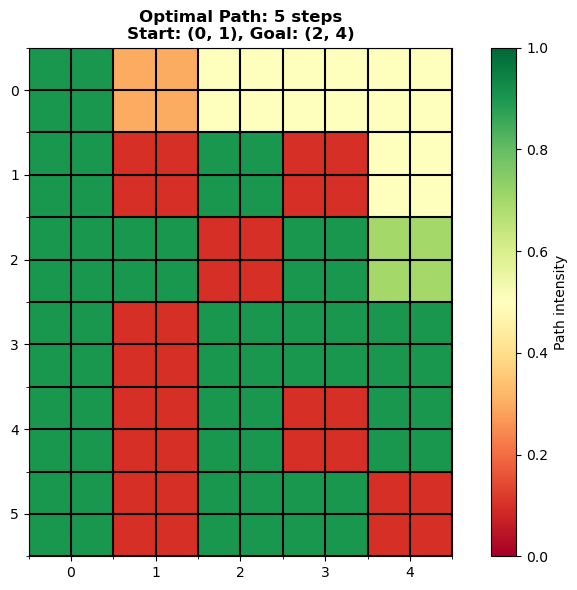

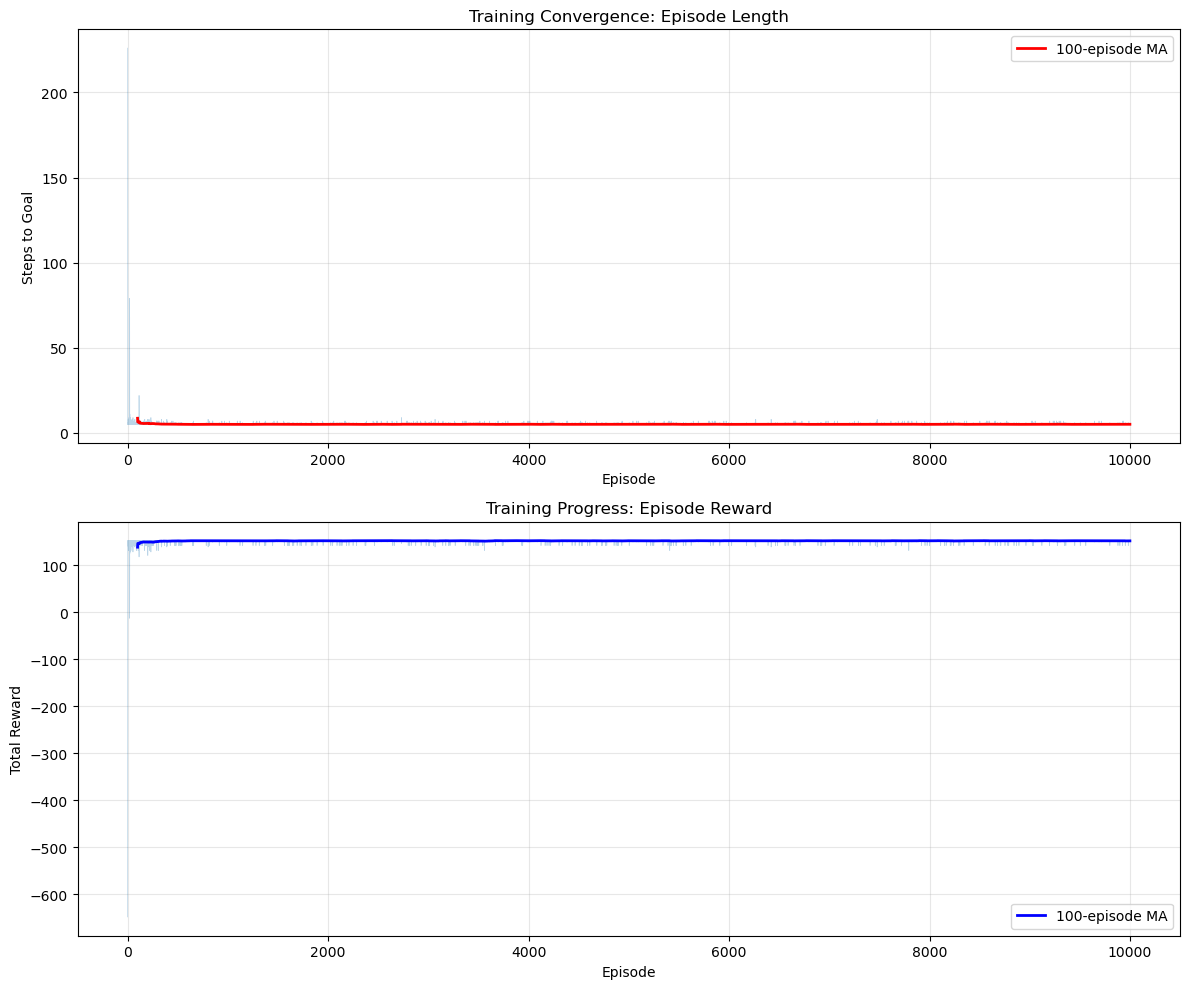


Processing: maze2.txt
Loaded maze from maze2.txt
Dimensions: 8x8
Start: (0, 0) (file format: 1, 1)
Goal: (7, 7) (file format: 8, 8)

Maze Configuration:
S = Start, G = Goal, # = Obstacle, . = Free
-----------------
|S . . . . . . . |
|. # # . # # # . |
|. . . . . . . . |
|. # . # # # . # |
|. . . . . . . . |
|. # # # . # # . |
|. . . . . . . . |
|. # . # # # . G |
-----------------

Training Q-learning for 10000 episodes...
Start: (0, 0), Goal: (7, 7)
Episode 1000/10000, Avg length (last 100): 14.09, Epsilon: 0.0100
Episode 2000/10000, Avg length (last 100): 14.12, Epsilon: 0.0100
Episode 3000/10000, Avg length (last 100): 14.16, Epsilon: 0.0100
Episode 4000/10000, Avg length (last 100): 14.20, Epsilon: 0.0100
Episode 5000/10000, Avg length (last 100): 14.18, Epsilon: 0.0100
Episode 6000/10000, Avg length (last 100): 14.08, Epsilon: 0.0100
Episode 7000/10000, Avg length (last 100): 14.09, Epsilon: 0.0100
Episode 8000/10000, Avg length (last 100): 14.26, Epsilon: 0.0100
Episode 9000/10

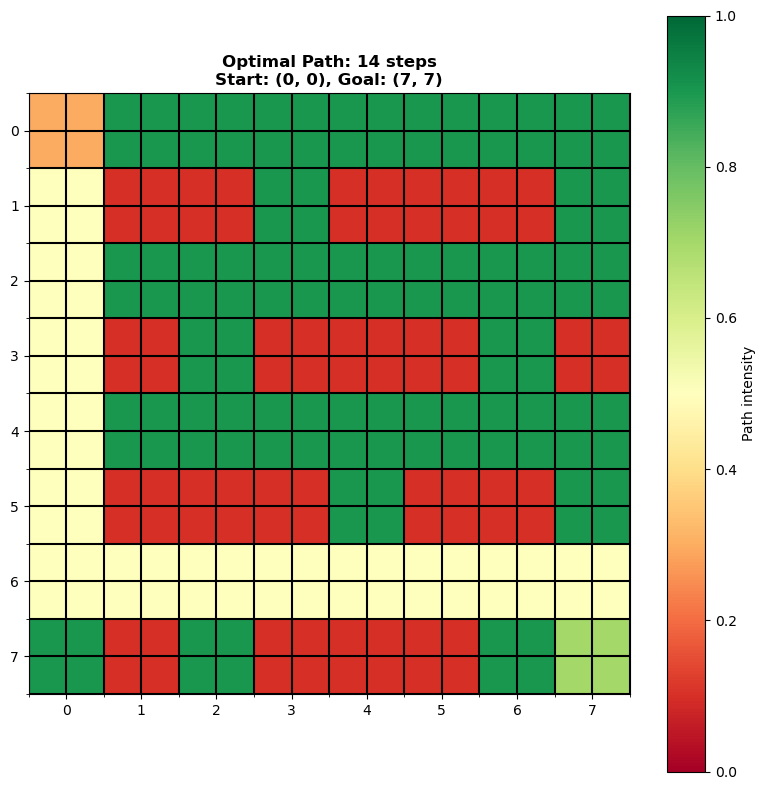

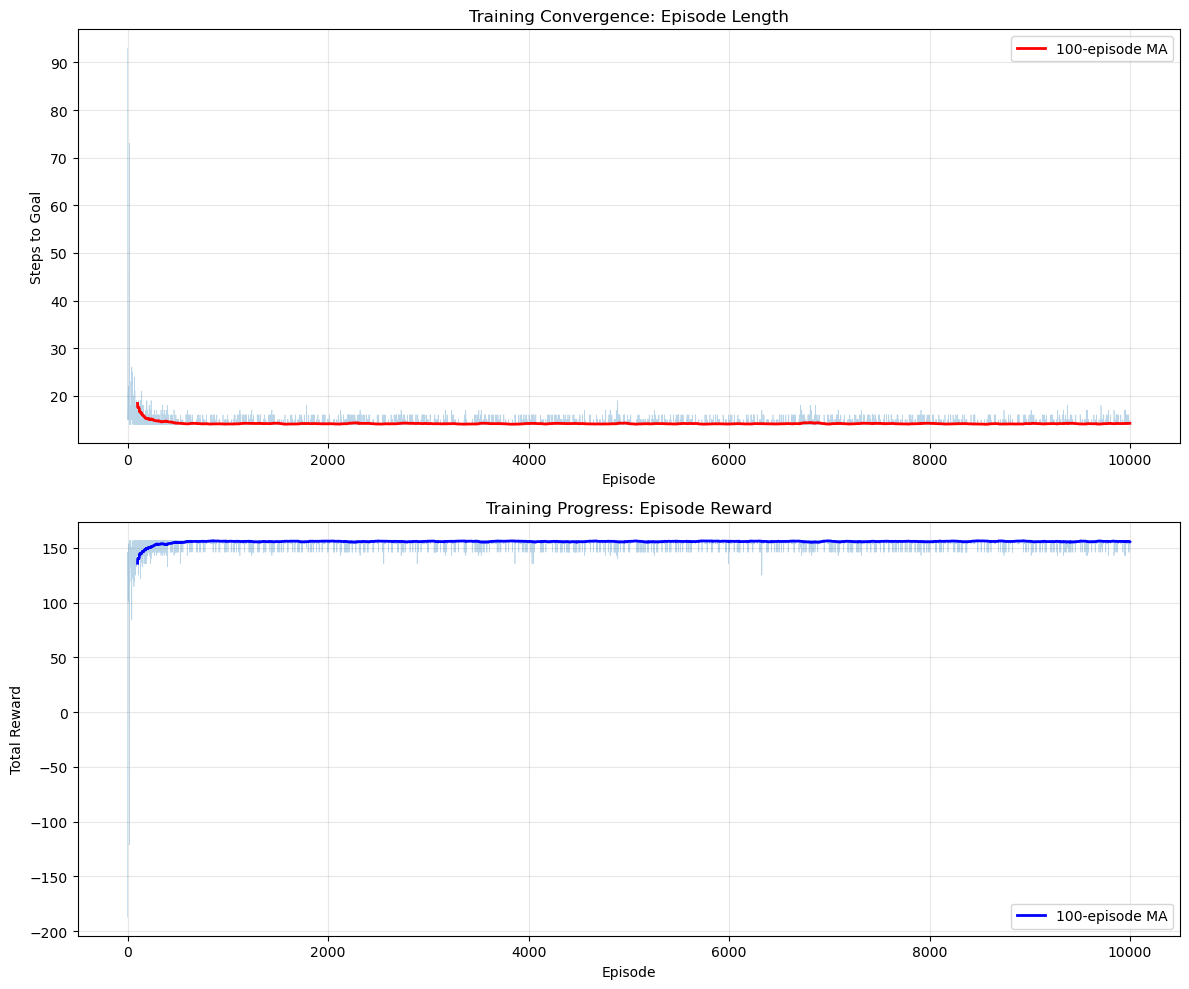


Part 3 Complete!


In [22]:
"""
6ELEN018W Applied Robotics - Coursework Part 3
Q-Learning Controller for Variable Maze Configurations

Student: [20223072 / w1961648]
Module: Applied Robotics
Academic Year: 2025/2026

This implementation extends Q-learning to handle arbitrary maze configurations
read from input files, demonstrating adaptability to different environments.
"""

import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import os


class ConfigurableMazeEnvironment:
    """
    Flexible maze environment that reads configuration from files.
    Supports variable sizes and obstacle configurations.
    """
    
    def __init__(self, maze_file=None):
        """
        Initialise maze either from file or with default configuration.
        
        Parameters:
            maze_file: Path to maze configuration file
        """
        if maze_file:
            self.load_from_file(maze_file)
        else:
            # Default maze if no file provided
            self.create_default_maze()
        
        self.action_space = ['N', 'E', 'S', 'W']
    
    def load_from_file(self, filename):
        """
        Load maze configuration from file following the specified format:
        Line 1: rows cols
        Line 2: start_row start_col
        Line 3: goal_row goal_col
        Remaining lines: maze grid (0=free, 1=obstacle)
        """
        try:
            with open(filename, 'r') as f:
                lines = f.readlines()
            
            # Parse maze dimensions
            rows, cols = map(int, lines[0].strip().split())
            
            # Parse start position (convert from 1-indexed to 0-indexed)
            start_row, start_col = map(int, lines[1].strip().split())
            self.start_pos = (start_row - 1, start_col - 1)
            
            # Parse goal position (convert from 1-indexed to 0-indexed)
            goal_row, goal_col = map(int, lines[2].strip().split())
            self.goal_pos = (goal_row - 1, goal_col - 1)
            
            # Parse maze grid
            self.maze = np.zeros((rows, cols), dtype=int)
            for i in range(rows):
                row_data = list(map(int, lines[3 + i].strip().split()))
                self.maze[i, :] = row_data
            
            self.rows, self.cols = self.maze.shape
            
            print(f"Loaded maze from {filename}")
            print(f"Dimensions: {self.rows}x{self.cols}")
            print(f"Start: {self.start_pos} (file format: {start_row}, {start_col})")
            print(f"Goal: {self.goal_pos} (file format: {goal_row}, {goal_col})")
            
            # Validate positions
            if not self.is_valid_position(self.start_pos[0], self.start_pos[1]):
                raise ValueError(f"Start position {self.start_pos} is invalid (obstacle or out of bounds)")
            if not self.is_valid_position(self.goal_pos[0], self.goal_pos[1]):
                raise ValueError(f"Goal position {self.goal_pos} is invalid (obstacle or out of bounds)")
            
        except FileNotFoundError:
            print(f"Error: File {filename} not found.")
            raise
        except Exception as e:
            print(f"Error loading maze: {e}")
            raise
    
    def create_default_maze(self):
        """Create default maze for testing."""
        self.maze = np.array([
            [0, 0, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 1, 0, 0, 1]
        ])
        self.rows, self.cols = self.maze.shape
        self.start_pos = (0, 1)  # row 1, col 2 in file format
        self.goal_pos = (2, 4)   # row 3, col 5 in file format
        
        print("Using default maze configuration")
    
    def is_valid_position(self, row, col):
        """Check if position is within bounds and not an obstacle."""
        if row < 0 or row >= self.rows or col < 0 or col >= self.cols:
            return False
        return self.maze[row, col] == 0
    
    def get_next_state(self, current_row, current_col, action):
        """
        Calculate next state given current position and action.
        If movement would hit obstacle/boundary, stay in place.
        """
        next_row, next_col = current_row, current_col
        
        if action == 'N':
            next_row = current_row - 1
        elif action == 'S':
            next_row = current_row + 1
        elif action == 'E':
            next_col = current_col + 1
        elif action == 'W':
            next_col = current_col - 1
        
        # Stay in current position if next position is invalid
        if not self.is_valid_position(next_row, next_col):
            return current_row, current_col
        
        return next_row, next_col
    
    def display_maze(self):
        """Print ASCII representation of maze."""
        print("\nMaze Configuration:")
        print("S = Start, G = Goal, # = Obstacle, . = Free")
        print("-" * (self.cols * 2 + 1))
        
        for i in range(self.rows):
            row_str = "|"
            for j in range(self.cols):
                if (i, j) == self.start_pos:
                    row_str += "S "
                elif (i, j) == self.goal_pos:
                    row_str += "G "
                elif self.maze[i, j] == 1:
                    row_str += "# "
                else:
                    row_str += ". "
            row_str += "|"
            print(row_str)
        
        print("-" * (self.cols * 2 + 1))


class AdaptiveQLearningController:
    """
    Q-learning controller that adapts to different maze configurations.
    Can learn optimal policies for variable environments.
    """
    
    def __init__(self, environment, learning_rate=0.15, discount_factor=0.9,
                 epsilon=0.2, epsilon_decay=0.995, min_epsilon=0.01):
        """
        Initialise Q-learning with parameters tuned for variable mazes.
        
        Hyperparameter rationale:
        - Higher learning_rate (0.15) for faster adaptation to new environments
        - Higher initial epsilon (0.2) for better exploration in unknown mazes
        - Standard discount_factor (0.9) balances short/long-term rewards
        """
        self.env = environment
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Q-table: Q[state][action] = value
        self.Q = defaultdict(lambda: defaultdict(float))
        
        self.training_metrics = {
            'episode_lengths': [],
            'episode_rewards': [],
            'convergence_episode': None
        }
    
    def get_reward(self, current_pos, next_pos, goal_pos, steps_taken):
        """
        Sophisticated reward structure encouraging efficient navigation.
        
        Reward design rationale:
        - Large reward for reaching goal incentivizes task completion
        - Penalty for each step encourages shorter paths
        - Heavy penalty for hitting walls discourages inefficient exploration
        - Distance-based shaping guides agent toward goal
        """
        if next_pos == goal_pos:
            # Bonus reward inversely proportional to steps (reward efficiency)
            efficiency_bonus = max(0, 50 - steps_taken * 0.5)
            return 100.0 + efficiency_bonus
        
        if next_pos == current_pos:  # Hit obstacle/boundary
            return -10.0
        
        # Calculate Manhattan distance to goal
        current_dist = abs(current_pos[0] - goal_pos[0]) + abs(current_pos[1] - goal_pos[1])
        next_dist = abs(next_pos[0] - goal_pos[0]) + abs(next_pos[1] - goal_pos[1])
        
        # Reward moving closer, penalize moving away
        distance_reward = (current_dist - next_dist) * 2.0
        
        # Base step penalty
        step_penalty = -1.0
        
        return step_penalty + distance_reward
    
    def select_action(self, state, training=True):
        """
        Epsilon-greedy policy for action selection.
        """
        if training and random.random() < self.epsilon:
            return random.choice(self.env.action_space)
        
        # Greedy action selection
        state_key = (state[0], state[1])
        q_values = {action: self.Q[state_key][action] 
                   for action in self.env.action_space}
        
        max_q = max(q_values.values())
        best_actions = [action for action, q in q_values.items() if q == max_q]
        
        return random.choice(best_actions)
    
    def train(self, num_episodes=10000, max_steps_per_episode=500, 
              convergence_window=100, convergence_threshold=0.01):
        """
        Train Q-learning until convergence or maximum episodes reached.
        
        Convergence detection:
        - Monitor average episode length over sliding window
        - Declare convergence when performance stabilizes
        """
        print(f"\nTraining Q-learning for {num_episodes} episodes...")
        print(f"Start: {self.env.start_pos}, Goal: {self.env.goal_pos}")
        
        recent_lengths = []
        
        for episode in range(num_episodes):
            current_pos = self.env.start_pos
            steps = 0
            episode_reward = 0
            
            while current_pos != self.env.goal_pos and steps < max_steps_per_episode:
                # Select and execute action
                action = self.select_action(current_pos, training=True)
                next_pos = self.env.get_next_state(current_pos[0], current_pos[1], action)
                
                # Observe reward
                reward = self.get_reward(current_pos, next_pos, 
                                        self.env.goal_pos, steps)
                episode_reward += reward
                
                # Q-learning update
                current_key = (current_pos[0], current_pos[1])
                next_key = (next_pos[0], next_pos[1])
                
                max_next_q = max([self.Q[next_key][a] 
                                 for a in self.env.action_space])
                
                current_q = self.Q[current_key][action]
                self.Q[current_key][action] = current_q + self.alpha * (
                    reward + self.gamma * max_next_q - current_q
                )
                
                current_pos = next_pos
                steps += 1
            
            # Record metrics
            self.training_metrics['episode_lengths'].append(steps)
            self.training_metrics['episode_rewards'].append(episode_reward)
            recent_lengths.append(steps)
            
            # Decay epsilon
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            # Check convergence
            if len(recent_lengths) > convergence_window:
                recent_lengths.pop(0)
                
                if episode > convergence_window:
                    recent_avg = np.mean(recent_lengths)
                    recent_std = np.std(recent_lengths)
                    
                    # Converged if low variance in recent performance
                    if recent_std < convergence_threshold * recent_avg:
                        if self.training_metrics['convergence_episode'] is None:
                            self.training_metrics['convergence_episode'] = episode
                            print(f"Converged at episode {episode}")
            
            # Progress updates
            if (episode + 1) % 1000 == 0:
                avg_length = np.mean(self.training_metrics['episode_lengths'][-100:])
                print(f"Episode {episode + 1}/{num_episodes}, "
                      f"Avg length (last 100): {avg_length:.2f}, "
                      f"Epsilon: {self.epsilon:.4f}")
        
        final_avg = np.mean(self.training_metrics['episode_lengths'][-100:])
        print(f"\nTraining complete!")
        print(f"Final average episode length: {final_avg:.2f}")
        
        if self.training_metrics['convergence_episode']:
            print(f"Convergence achieved at episode: "
                  f"{self.training_metrics['convergence_episode']}")
    
    def get_optimal_path(self, start_pos=None, goal_pos=None, max_steps=200):
        """
        Execute learned policy to find optimal path.
        """
        if start_pos is None:
            start_pos = self.env.start_pos
        if goal_pos is None:
            goal_pos = self.env.goal_pos
        
        path = [start_pos]
        current_pos = start_pos
        steps = 0
        visited = set([start_pos])
        
        while current_pos != goal_pos and steps < max_steps:
            action = self.select_action(current_pos, training=False)
            next_pos = self.env.get_next_state(current_pos[0], current_pos[1], action)
            
            # Prevent infinite loops
            if next_pos in visited and len(visited) > 5:
                # If stuck in loop, try alternative action
                for alt_action in self.env.action_space:
                    alt_pos = self.env.get_next_state(current_pos[0], 
                                                      current_pos[1], alt_action)
                    if alt_pos not in visited:
                        next_pos = alt_pos
                        action = alt_action
                        break
            
            visited.add(next_pos)
            path.append(next_pos)
            current_pos = next_pos
            steps += 1
        
        return path


def visualize_maze_and_path(env, path, save_path=None):
    """
    Create visualization of maze with optimal path.
    """
    fig, ax = plt.subplots(figsize=(max(8, env.cols), max(6, env.rows)))
    
    # Create display array
    maze_display = np.copy(env.maze).astype(float)
    maze_display = np.where(maze_display == 1, 0.1, 0.9)  # Obstacles dark
    
    # Mark path
    for i, pos in enumerate(path):
        if pos != env.start_pos and pos != env.goal_pos:
            maze_display[pos[0], pos[1]] = 0.5
    
    # Mark start and goal
    maze_display[env.start_pos[0], env.start_pos[1]] = 0.3
    maze_display[env.goal_pos[0], env.goal_pos[1]] = 0.7
    
    im = ax.imshow(maze_display, cmap='RdYlGn', interpolation='nearest',
                   vmin=0, vmax=1)
    
    # Add grid
    ax.set_xticks(np.arange(env.cols))
    ax.set_yticks(np.arange(env.rows))
    ax.grid(which='both', color='black', linestyle='-', linewidth=1.5)
    ax.set_xticks(np.arange(-.5, env.cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, env.rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
    
    # Labels
    ax.set_title(f'Optimal Path: {len(path)-1} steps\n'
                f'Start: {env.start_pos}, Goal: {env.goal_pos}',
                fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Path intensity')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()


def plot_training_metrics(metrics, save_path=None):
    """
    Plot training convergence metrics.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    episodes = range(len(metrics['episode_lengths']))
    
    # Episode lengths
    ax1.plot(episodes, metrics['episode_lengths'], alpha=0.3, linewidth=0.5)
    
    # Moving average
    window = 100
    if len(metrics['episode_lengths']) >= window:
        moving_avg = np.convolve(metrics['episode_lengths'], 
                                np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episodes)), moving_avg, 
                color='red', linewidth=2, label=f'{window}-episode MA')
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Steps to Goal')
    ax1.set_title('Training Convergence: Episode Length')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Episode rewards
    ax2.plot(episodes, metrics['episode_rewards'], alpha=0.3, linewidth=0.5)
    
    if len(metrics['episode_rewards']) >= window:
        reward_ma = np.convolve(metrics['episode_rewards'], 
                               np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episodes)), reward_ma, 
                color='blue', linewidth=2, label=f'{window}-episode MA')
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Total Reward')
    ax2.set_title('Training Progress: Episode Reward')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


def create_sample_maze_files():
    """
    Create sample maze configuration files for testing.
    """
    # Sample Maze 1: 6x5 from specification
    maze1_content = """6 5
1 2
3 5
0 0 0 0 0
0 1 0 1 0
0 0 1 0 0
0 1 0 0 0
0 1 0 1 0
0 1 0 0 1"""
    
    with open('maze1.txt', 'w') as f:
        f.write(maze1_content)
    
    # Sample Maze 2: Larger maze
    maze2_content = """8 8
1 1
8 8
0 0 0 0 0 0 0 0
0 1 1 0 1 1 1 0
0 0 0 0 0 0 0 0
0 1 0 1 1 1 0 1
0 0 0 0 0 0 0 0
0 1 1 1 0 1 1 0
0 0 0 0 0 0 0 0
0 1 0 1 1 1 0 0"""
    
    with open('maze2.txt', 'w') as f:
        f.write(maze2_content)
    
    print("Created sample maze files: maze1.txt, maze2.txt")


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("="*70)
    print("Q-Learning Controller for Different Maze Configurations")
    print("6ELEN018W Applied Robotics Coursework - Part 3")
    print("="*70)
    
    # Create sample maze files
    create_sample_maze_files()
    
    # Test with multiple mazes
    maze_files = ['maze1.txt', 'maze2.txt']
    
    for maze_file in maze_files:
        print(f"\n{'='*70}")
        print(f"Processing: {maze_file}")
        print('='*70)
        
        # Load maze
        env = ConfigurableMazeEnvironment(maze_file)
        env.display_maze()
        
        # Initialize controller
        controller = AdaptiveQLearningController(
            environment=env,
            learning_rate=0.15,
            discount_factor=0.9,
            epsilon=0.2
        )
        
        # Train
        controller.train(num_episodes=10000, max_steps_per_episode=500)
        
        # Get optimal path
        print(f"\nFinding optimal path...")
        path = controller.get_optimal_path()
        
        print(f"Optimal path length: {len(path)-1} steps")
        print(f"Path: {path[:10]}{'...' if len(path) > 10 else ''}")
        
        # Visualize
        visualize_maze_and_path(env, path, 
                               save_path=f"path_{maze_file.replace('.txt', '.png')}")
        
        # Plot training metrics
        plot_training_metrics(controller.training_metrics,
                             save_path=f"training_{maze_file.replace('.txt', '.png')}")
    
    print("\n" + "="*70)
    print("Part 3 Complete!")
    print("="*70)